In [18]:
import torch
import os
import re
import pandas as pd
import numpy as np
from transformers import BertTokenizer
from torch.utils.data import Dataset
from sklearn.model_selection import KFold
from transformers import BertForMaskedLM
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from transformers import BertForSequenceClassification
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import zhon.hanzi

## evaluation ##
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [14]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.backends.cudnn.enabled)
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())
os.environ["CUDA_VISIBLE_DEVICES"]= "1"

1.2.0
True
10.0.130
True
Available devices  2
Current cuda device  0


In [3]:
class SentimentDataset(Dataset):
    def __init__(self, mode, tokenizer):
        assert mode in ["train", "test"]
        self.mode = mode
        if mode == "train":
            self.df = train_df
        elif mode == "test":
            self.df = test_df
        self.len = len(self.df)
        self.label_map = {'neutral': 0, 'positive': 1, 'negative': 2}
        self.tokenizer = tokenizer
    
    def __getitem__(self, idx):
        if self.mode == "test":
            text = self.df["Comment"].values[idx]
            label_tensor = None
        else:
            text = self.df["Comment"].values[idx]
            label = self.df["Label"].values[idx]
            label_id = self.label_map[label]
            label_tensor = torch.tensor(label_id)
            
        word_pieces = ["[CLS]"]
        tokens = self.tokenizer.tokenize(text)
        word_pieces += tokens
        len_of_text = len(word_pieces)
        
        ids = self.tokenizer.convert_tokens_to_ids(word_pieces)
        tokens_tensor = torch.tensor(ids)
        
        segments_tensor = torch.tensor([0] * len_of_text, dtype=torch.long)
        return (tokens_tensor, segments_tensor, label_tensor)
    
    def __len__(self):
        return self.len

In [4]:
def evaluation(answer, predict):
    print("accuracy: ", round(accuracy_score(answer, predict), 4))
    print("precision_score: ", round(precision_score(answer, predict, average="macro"), 4))
    print("recall_score: ", round(recall_score(answer, predict, average="macro"), 4))
    print("f1_score: ", round(f1_score(answer, predict, average="macro"), 4))
    
    matrix = confusion_matrix(answer, predict)
    
    plt.figure(figsize=(4, 4))
    sns.heatmap(matrix, annot = True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    all_sample_title = 'F1 Score: {0}'.format(round(f1_score(answer, predict, average="macro"), 4))
    plt.title(all_sample_title, size = 15)
    plt.show

In [5]:
def get_predictions(model, dataloader, compute_acc=False):
    predictions = None
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            if next(model.parameters()).is_cuda:
                data = [t.to("cuda:1") for t in data if t is not None]
            tokens_tensors, segments_tensors, masks_tensors = data[:3]
            outputs = model(input_ids=tokens_tensors, 
                            token_type_ids=segments_tensors, 
                            attention_mask=masks_tensors)
            logits = outputs[0]
            _, pred = torch.max(logits.data, 1)
            
            if compute_acc:
                labels = data[3]
                total += labels.size(0)
                correct += (pred == labels).sum().item()
                
            if predictions is None:
                predictions = pred
            else:
                predictions = torch.cat((predictions, pred))
                
    if compute_acc:
        acc = correct / total
        return predictions, acc, logits
    
    return predictions, logits

In [6]:
def create_mini_batch(samples):
    tokens_tensors = [s[0] for s in samples]
    segments_tensors = [s[1] for s in samples]
    
    if samples[0][2] is not None:
        label_ids = torch.stack([s[2] for s in samples])
    else:
        label_ids = None
    
    tokens_tensors = pad_sequence(tokens_tensors, batch_first=True)
    segments_tensors = pad_sequence(segments_tensors, batch_first=True)
    
    masks_tensors = torch.zeros(tokens_tensors.shape, dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(tokens_tensors != 0, 1)
    
    return tokens_tensors, segments_tensors, masks_tensors, label_ids

In [15]:
def get_learnable_params(module):
    return [p for p in module.parameters() if p.requires_grad]

In [16]:
raw_data = pd.read_csv("data_2.csv", names=["Comment", "Label"], header=None)
raw_data.head()

,Comment,Label
0,千呼万唤始出来，,neutral
1,尼康的APSC小相机终于发布了，,neutral
2,COOLPIX A. 你怎么看呢？,neutral
3,我看，尼康是挤牙膏挤惯了啊，,neutral
4,1，外观既没有V1时尚，,negative


In [19]:
h_regex = re.compile('[%s]' % zhon.hanzi.punctuation)
remove_punctuation = []
for comment in list(raw_data["Comment"].values):
    remove_punctuation.append(h_regex.sub('', comment))

In [20]:
raw_data["Comment"] = remove_punctuation

In [22]:
PRETRAINED_MODEL_NAME = "bert-base-chinese"
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)

In [23]:
NUM_LABELS = 3
num_of_kfold = 5
BATCH_SIZE = 64
EPOCHS = 6

[epoch 1] loss: 42.840, acc: 0.854
[epoch 2] loss: 24.122, acc: 0.941
[epoch 3] loss: 12.283, acc: 0.977
[epoch 4] loss: 5.053, acc: 0.986
[epoch 5] loss: 2.350, acc: 0.996
[epoch 6] loss: 1.883, acc: 0.970
accuracy:  0.8789
precision_score:  0.8628
recall_score:  0.6266
f1_score:  0.6979
[epoch 1] loss: 42.005, acc: 0.862
[epoch 2] loss: 25.370, acc: 0.937
[epoch 3] loss: 13.668, acc: 0.980
[epoch 4] loss: 6.037, acc: 0.992
[epoch 5] loss: 3.967, acc: 0.994
[epoch 6] loss: 2.288, acc: 0.994
accuracy:  0.8469
precision_score:  0.7436
recall_score:  0.713
f1_score:  0.7245
[epoch 1] loss: 44.126, acc: 0.856
[epoch 2] loss: 27.492, acc: 0.926
[epoch 3] loss: 17.179, acc: 0.955
[epoch 4] loss: 9.356, acc: 0.984
[epoch 5] loss: 4.893, acc: 0.989
[epoch 6] loss: 3.259, acc: 0.993
accuracy:  0.8737
precision_score:  0.7808
recall_score:  0.7134
f1_score:  0.7404
[epoch 1] loss: 44.726, acc: 0.823
[epoch 2] loss: 26.169, acc: 0.915
[epoch 3] loss: 14.810, acc: 0.960
[epoch 4] loss: 9.613, acc

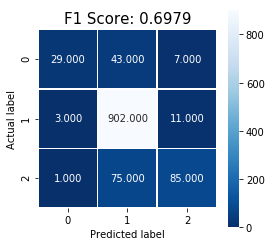

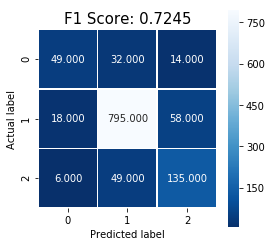

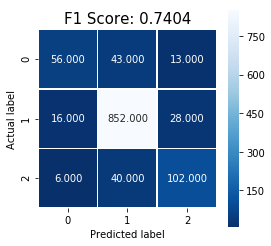

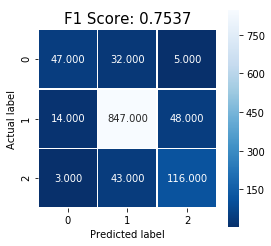

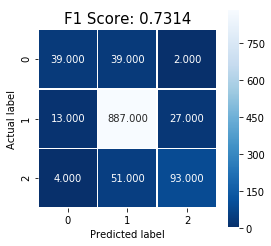

In [24]:
kf = KFold(n_splits = num_of_kfold, shuffle = True, random_state = 2)
fold_num = 0
for train_index, test_index in kf.split(raw_data):
    # if fold_num > 0:
    #     break
    print("===============================================================")
    train_df = raw_data.iloc[train_index, :].reset_index(drop=True)
    test_df = raw_data.iloc[test_index, :].reset_index(drop=True)
    trainset = SentimentDataset("train", tokenizer=tokenizer)
    trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, collate_fn=create_mini_batch)
    model = BertForSequenceClassification.from_pretrained(PRETRAINED_MODEL_NAME, num_labels=NUM_LABELS)
    model = model.to("cuda:1")
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
    
    for epoch in range(EPOCHS):
        running_loss = 0.0
        for data in trainloader:
            tokens_tensors, segments_tensors, \
            masks_tensors, labels = [t.to("cuda:1") for t in data]
            optimizer.zero_grad()
            outputs = model(input_ids=tokens_tensors, 
                            token_type_ids=segments_tensors, 
                            attention_mask=masks_tensors, 
                            labels=labels)
            loss = outputs[0]
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        _, acc, logit_train = get_predictions(model, trainloader, compute_acc=True)
        print('[epoch %d] loss: %.3f, acc: %.3f' % (epoch + 1, running_loss, acc))
    
    testset = SentimentDataset("test", tokenizer=tokenizer)
    testloader = DataLoader(testset, batch_size=256, collate_fn=create_mini_batch)
    predictions, logit_test = get_predictions(model, testloader)
    
    result = []
    for pred in predictions:
        if pred == 0:
            result.append("neutral")
        elif pred == 1:
            result.append("positive")
        elif pred == 2:
            result.append("negative")
    test_df["Result"] = result
    evaluation(test_df["Label"], test_df["Result"])
    fold_num += 1